# Analysis of BTSP-enabled local sensitive hashing performance

In [1]:
# import dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
import xgboost as xgb

## Load dataset and check data

In [2]:
# load results.csv
results = pd.read_csv('merged_results.csv')

# print dataset length
print(len(results))

# print schema
print(results.dtypes)

1680
Unnamed: 0             int64
dataset_name          object
training_data_num      int64
hash_length            int64
space_ratio            int64
binary_mode             bool
sampling_ratio       float64
random_seed            int64
experiment_index       int64
input_dim              int64
embedding_size         int64
btsp_fq              float64
btsp_mAP             float64
fly_mAP              float64
wta_mAP              float64
lsh_mAP              float64
dtype: object


## Relative importance analysis of each parameter

To provide a high-level comprehension of the dataset, we use XGBoost library to analyze the impact of each parameter on the performance of the model.

This section is for empirical analysis only, as we use a simple logistic regression model that may not precisely reflect the causal relationship between the parameters and the performance of the model.

[0]	eval-rmse:0.10103211259350435
{'hash_length': 81.0, 'space_ratio': 35.0, 'binary_mode': 10.0, 'sampling_ratio': 34.0}
[1.         0.43209877 0.12345679 0.41975309]
[0]	eval-rmse:0.08103953300854182
{'hash_length': 65.0, 'space_ratio': 37.0, 'binary_mode': 10.0, 'sampling_ratio': 29.0}
[1.         0.56923077 0.15384615 0.44615385]
[0]	eval-rmse:0.09304737796347516
{'hash_length': 40.0, 'space_ratio': 32.0, 'binary_mode': 2.0, 'sampling_ratio': 14.0}
[1.   0.8  0.05 0.35]
[0]	eval-rmse:0.06879297745726781
{'hash_length': 47.0, 'space_ratio': 0, 'binary_mode': 0, 'sampling_ratio': 0}
[1. 0. 0. 0.]


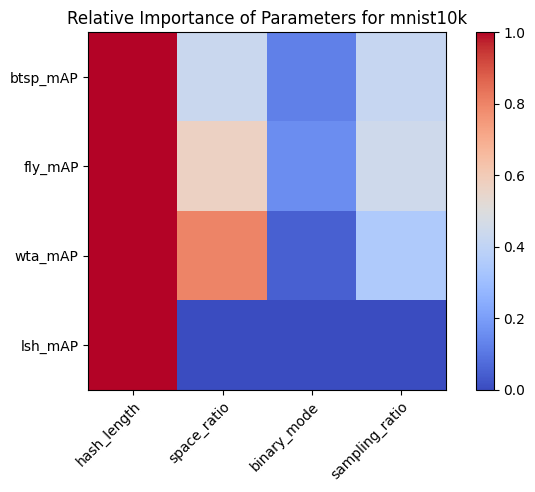

[0]	eval-rmse:0.05397553404334860
{'hash_length': 27.0, 'space_ratio': 8.0, 'binary_mode': 10.0, 'sampling_ratio': 23.0}
[1.         0.2962963  0.37037037 0.85185185]
[0]	eval-rmse:0.04149783881562218
{'hash_length': 87.0, 'space_ratio': 32.0, 'binary_mode': 10.0, 'sampling_ratio': 38.0}
[1.         0.36781609 0.11494253 0.43678161]
[0]	eval-rmse:0.04687824251043251
{'hash_length': 22.0, 'space_ratio': 0, 'binary_mode': 0, 'sampling_ratio': 0}
[1. 0. 0. 0.]
[0]	eval-rmse:0.04606193658240897
{'hash_length': 40.0, 'space_ratio': 0, 'binary_mode': 0, 'sampling_ratio': 0}
[1. 0. 0. 0.]


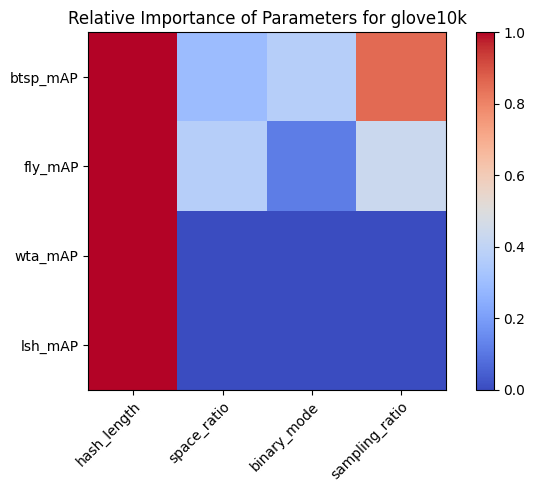

[0]	eval-rmse:0.11770251840221084
{'hash_length': 30.0, 'space_ratio': 21.0, 'binary_mode': 10.0, 'sampling_ratio': 21.0}
[1.         0.7        0.33333333 0.7       ]
[0]	eval-rmse:0.08375268210964371
{'hash_length': 56.0, 'space_ratio': 57.0, 'binary_mode': 22.0, 'sampling_ratio': 40.0}
[0.98245614 1.         0.38596491 0.70175439]
[0]	eval-rmse:0.06654027230914542
{'hash_length': 50.0, 'space_ratio': 9.0, 'binary_mode': 3.0, 'sampling_ratio': 3.0}
[1.   0.18 0.06 0.06]
[0]	eval-rmse:0.07999836120665565
{'hash_length': 50.0, 'space_ratio': 0, 'binary_mode': 0, 'sampling_ratio': 0}
[1. 0. 0. 0.]


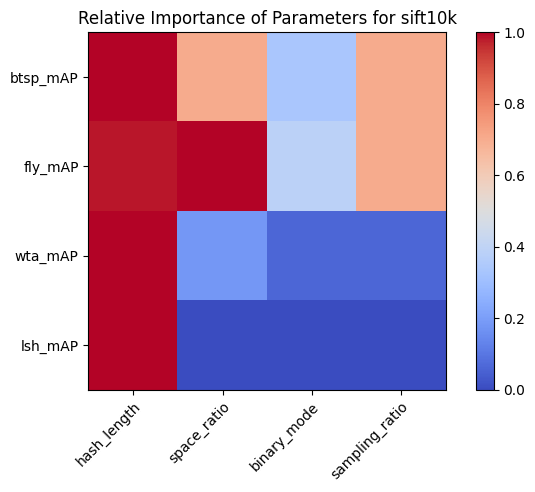

[0]	eval-rmse:0.06778518782105927
{'hash_length': 37.0, 'space_ratio': 27.0, 'binary_mode': 10.0, 'sampling_ratio': 28.0}
[1.         0.72972973 0.27027027 0.75675676]
[0]	eval-rmse:0.05595565552113443
{'hash_length': 60.0, 'space_ratio': 26.0, 'binary_mode': 10.0, 'sampling_ratio': 10.0}
[1.         0.43333333 0.16666667 0.16666667]
[0]	eval-rmse:0.04114524628023547
{'hash_length': 45.0, 'space_ratio': 0, 'binary_mode': 0, 'sampling_ratio': 0}
[1. 0. 0. 0.]
[0]	eval-rmse:0.03474972803155780
{'hash_length': 50.0, 'space_ratio': 20.0, 'sampling_ratio': 20.0, 'binary_mode': 0}
[1.  0.4 0.4 0. ]


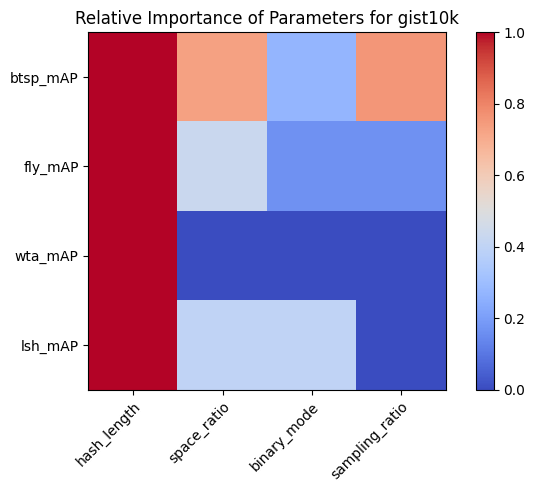

In [ ]:
# data cleaning
# keep the columns we need
# dataset_name, hash_length, space_ratio, binary_mode, sampling_ratio, and all mAP columns
meta_results = results.drop(columns=["training_data_num", "random_seed", "experiment_index", "input_dim", "embedding_size", "btsp_fq"])
# remove index column
meta_results = meta_results.drop(columns=["Unnamed: 0"])

# separate data for each dataset
datasets = meta_results["dataset_name"].unique()
for dataset in datasets:
    # XGB analysis
    curr_dataset_data = meta_results[meta_results["dataset_name"] == dataset]
    # remove dataset_name column
    curr_dataset_data = curr_dataset_data.drop(columns=["dataset_name"])
    # separate parameters and mAP columns
    mAP_types = ["btsp_mAP", "fly_mAP", "wta_mAP", "lsh_mAP"]
    curr_dataset_params = curr_dataset_data.drop(mAP_types, axis=1)
    # normalize the parameters
    curr_dataset_params = (curr_dataset_params - curr_dataset_params.mean()) / curr_dataset_params.std()
    
    # prepare XGBoost data
    X = curr_dataset_params
    # for each mAP type, use XGBoost to find the importance of each parameter
    mAP_types_importance = []
    for mAP_type in mAP_types:
        y = curr_dataset_data[mAP_type]
        dtrain = xgb.DMatrix(X, label=y)
        
        # set parameters
        # choose a parameter suitable for non-linear regression
        params = {
            'objective': 'reg:logistic',
            'booster': 'gbtree',
            'eta': 0.05,
        }
        # train the model
        bst = xgb.train(params, dtrain)
        # print error
        print(bst.eval(dtrain))
        
        # get feature importance and convert to numpy array
        importance = bst.get_score(importance_type='weight')
        # check if each parameter is in the importance
        # if not, add it with 0 importance
        for param in curr_dataset_params.columns:
            if param not in importance:
                importance[param] = 0
        # for debugging
        # print(importance)
        # normalize the importance
        importance = np.array(list(importance.values()))
        importance = importance / importance.max()
        # print(importance)
        
        mAP_types_importance.append(importance)
    
    # plot importance heatmap
    norm = plt.Normalize(0, 1)
    fig, ax = plt.subplots()
    im = ax.imshow(mAP_types_importance, norm=norm, cmap='coolwarm')
    ax.set_xticks(np.arange(len(curr_dataset_params.columns)))
    ax.set_yticks(np.arange(len(mAP_types)))
    ax.set_xticklabels(curr_dataset_params.columns)
    ax.set_yticklabels(mAP_types)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fig.tight_layout()
    # add title
    plt.title("Relative Importance of Parameters for " + dataset)
    # add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    
    plt.show()
    # close the plot
    plt.close()
    


We verify the results of the analysis by examining the importance `space_ratio`, `binary_mode` and `sampling_ratio` to `wta_mAP` and `lsh_mAP`. These two algorithms are independent to these parameters, so we expect the importance of these parameters to be 0. Despite some exceptions, the results are overall consistent with our expectations.

One key observation is that `binary_mode` seems to have a neglegible impact on the performance of all algorithms and `hash_length` is the most important parameter for all algorithms. Other parameters have a relatively small impact on the performance of the algorithms and their impact may be dataset-dependent.

## Numerical performance analysis

### The impact of `binary_mode` on the performance of the algorithms

As `binary_mode` has no effect on `wta_mAP` and `lsh_mAP`, we only examine its impact on `btsp_mAP` and `fly_mAP`, respectively. We compare the performance of the algorithms with and without `binary_mode` and calculate the difference ratio of performance with:

$$\text{Difference ratio} = \frac{\text{mAP with binary\_mode} - \text{mAP without binary\_mode}}{\min(\text{mAP with binary\_mode}, \text{mAP without binary\_mode})}$$

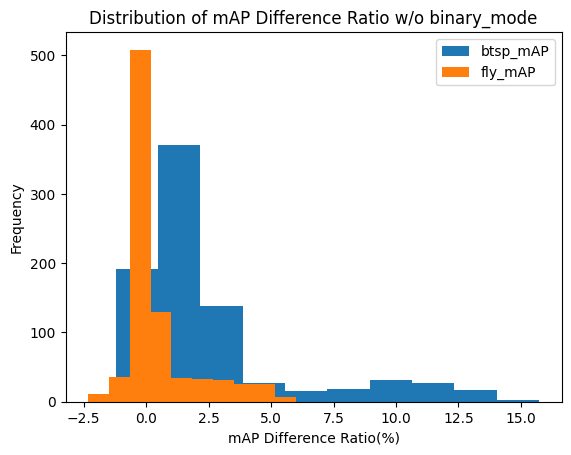

In [3]:
# load results.csv
results = pd.read_csv('merged_results.csv')

# keep the columns we need
# dataset_name, hash_length, space_ratio, binary_mode, sampling_ratio, btsp_mAP and fly_mAP
meta_results = results.drop(columns=["training_data_num", "random_seed", "experiment_index", "input_dim", "embedding_size", "btsp_fq", "wta_mAP", "lsh_mAP"])
# remove index column
meta_results = meta_results.drop(columns=["Unnamed: 0"])

# compare the mAP of each algorithm w/o binary_mode on all datasets
# separate data for binary_mode enabled and disabled
binary_mode_enabled = meta_results[meta_results["binary_mode"] == True]
binary_mode_disabled = meta_results[meta_results["binary_mode"] == False]
# sort two datasets by same order, ensure other parameters are the same for same index
binary_mode_enabled = binary_mode_enabled.sort_values(by=["dataset_name", "hash_length", "space_ratio", "sampling_ratio"])
binary_mode_disabled = binary_mode_disabled.sort_values(by=["dataset_name", "hash_length", "space_ratio", "sampling_ratio"])
# calculate mAP difference ratio
btsp_mAP_diff = binary_mode_enabled["btsp_mAP"].to_numpy() - binary_mode_disabled["btsp_mAP"].to_numpy()
fly_mAP_diff = binary_mode_enabled["fly_mAP"].to_numpy() - binary_mode_disabled["fly_mAP"].to_numpy()
btsp_mAP_min = np.minimum(binary_mode_enabled["btsp_mAP"].to_numpy(), binary_mode_disabled["btsp_mAP"].to_numpy())
fly_mAP_min = np.minimum(binary_mode_enabled["fly_mAP"].to_numpy(), binary_mode_disabled["fly_mAP"].to_numpy())
# for debugging
# print(btsp_mAP_diff)
btsp_mAP_diff_ratio = btsp_mAP_diff / btsp_mAP_min
fly_mAP_diff_ratio = fly_mAP_diff / fly_mAP_min
# plot distribution of mAP difference ratio
fig, ax = plt.subplots()
ax.hist(btsp_mAP_diff_ratio, label='btsp_mAP')
ax.hist(fly_mAP_diff_ratio, label='fly_mAP')
ax.legend()
ax.set_xlabel("mAP Difference Ratio(%)")
ax.set_ylabel("Frequency")
plt.title("Distribution of mAP Difference Ratio w/o binary_mode")
plt.savefig("mAP_diff_ratio_binary_mode.svg")
plt.show()
# save as svg
# close the plot
plt.close()

The results show that `binary_mode` has a negligible impact on the performance of the algorithms. We also show that adding `binary_mode` will slightly increase the performance of the algorithms, given the majority of the difference ratios are positive.

### Parameter-specific performance analysis between BTSP and FLY algorithms

From empirical analysis, we find that `hash_length`, `space_ratio` and `sampling_ratio` all have considerable impact on the performance of the algorithms, and their impact may be dataset-dependent. Therefore, we plot the difference ratio of performance between the BTSP and FLY algorithms to find out in which range of these parameters the BTSP algorithm outperforms the FLY algorithm.

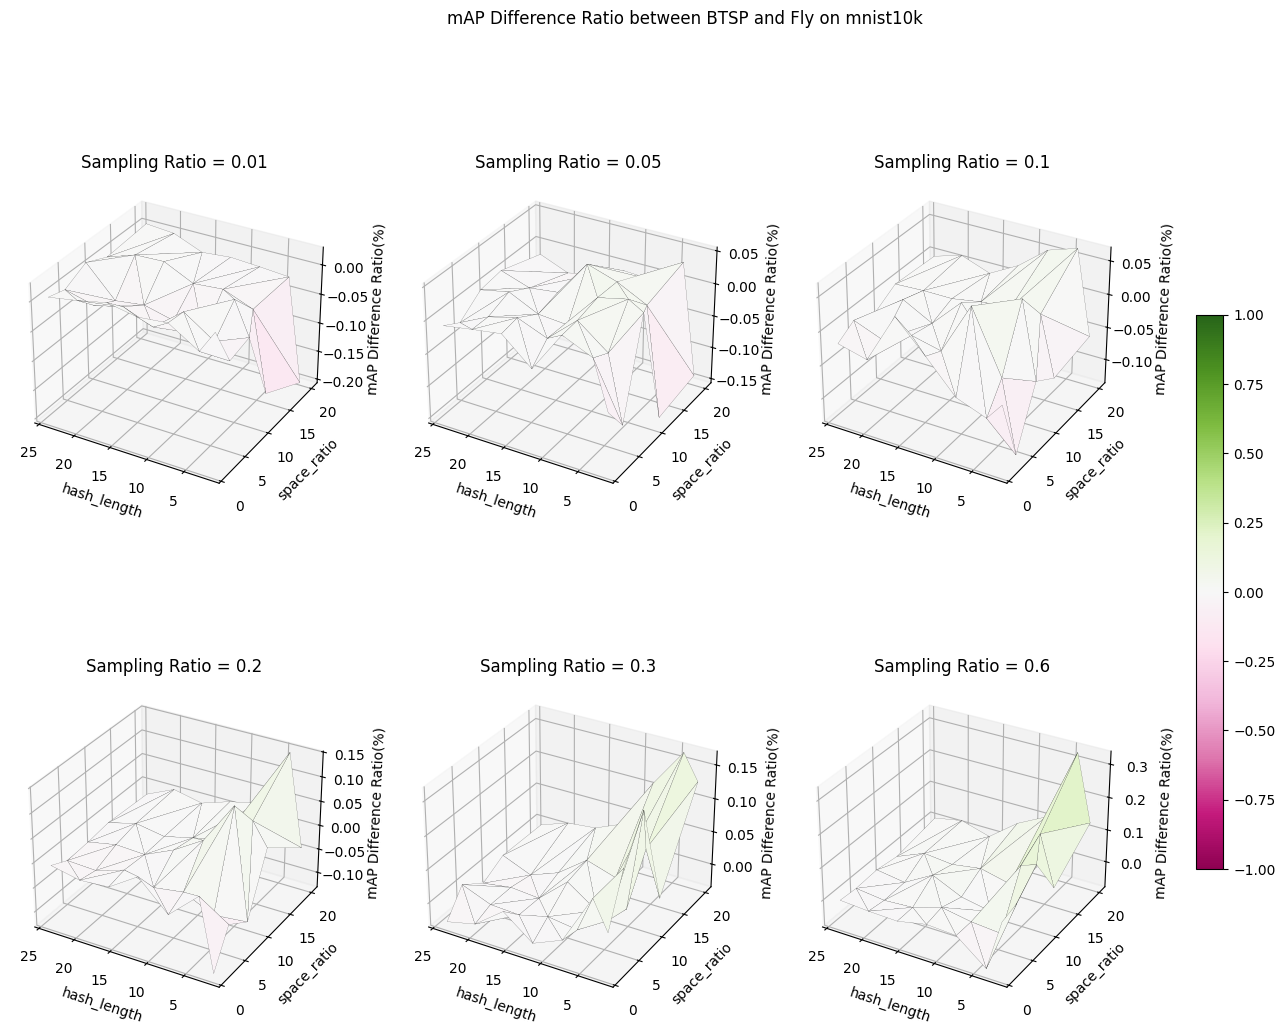

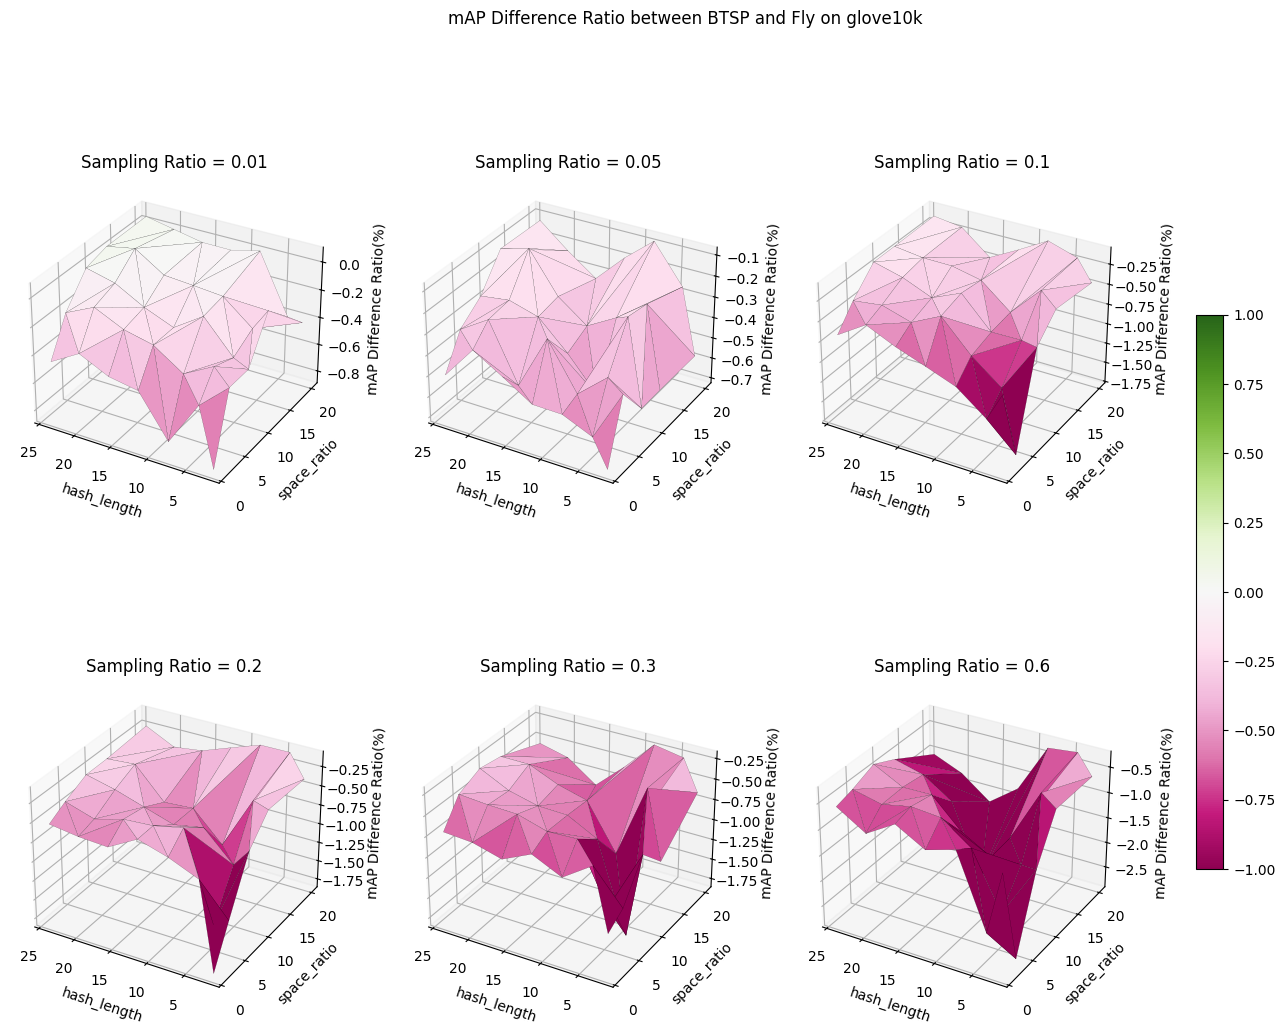

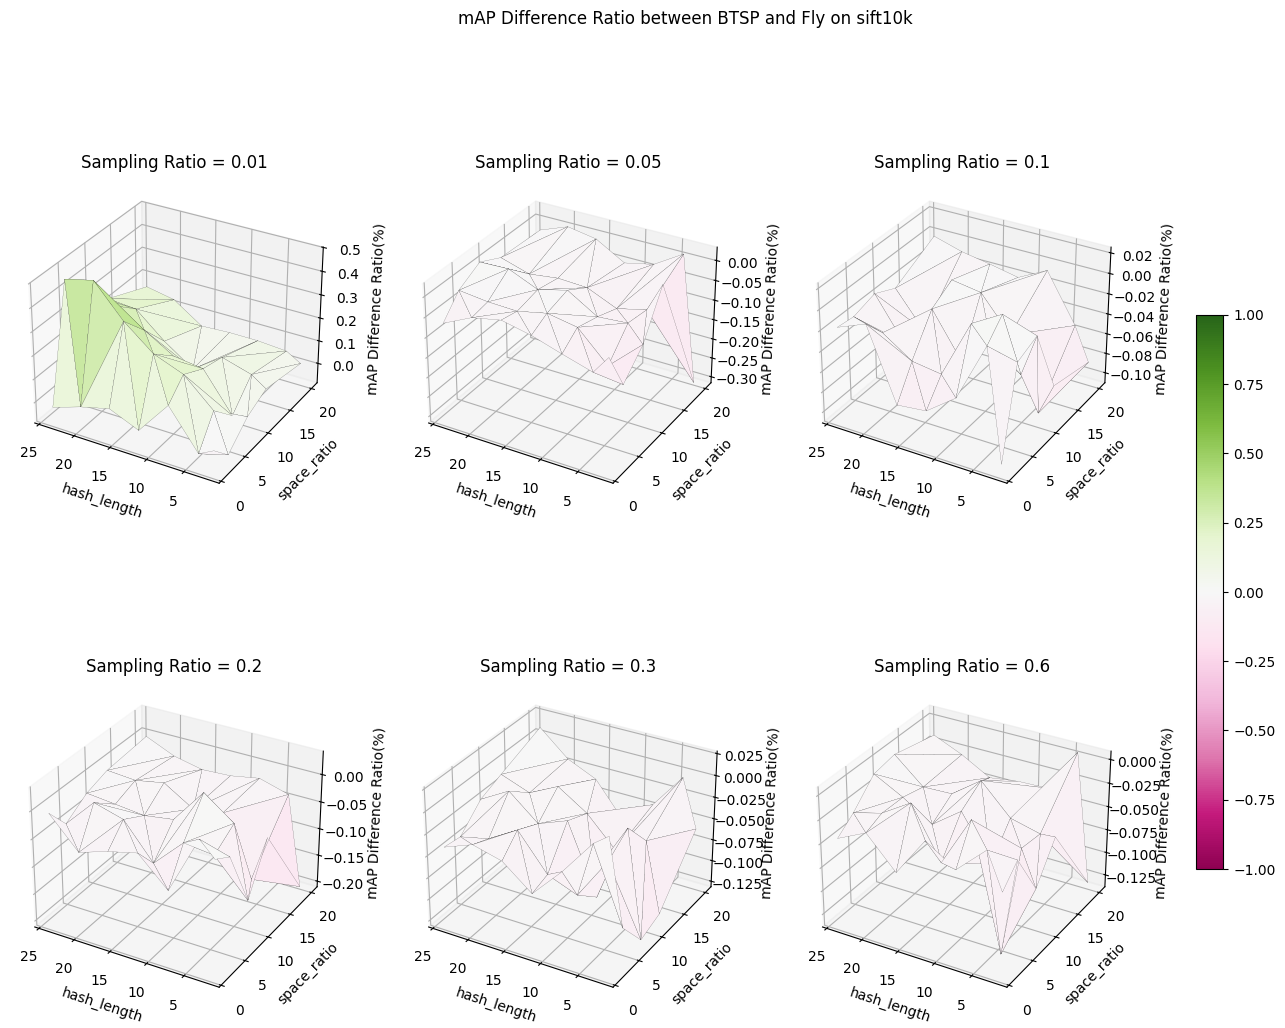

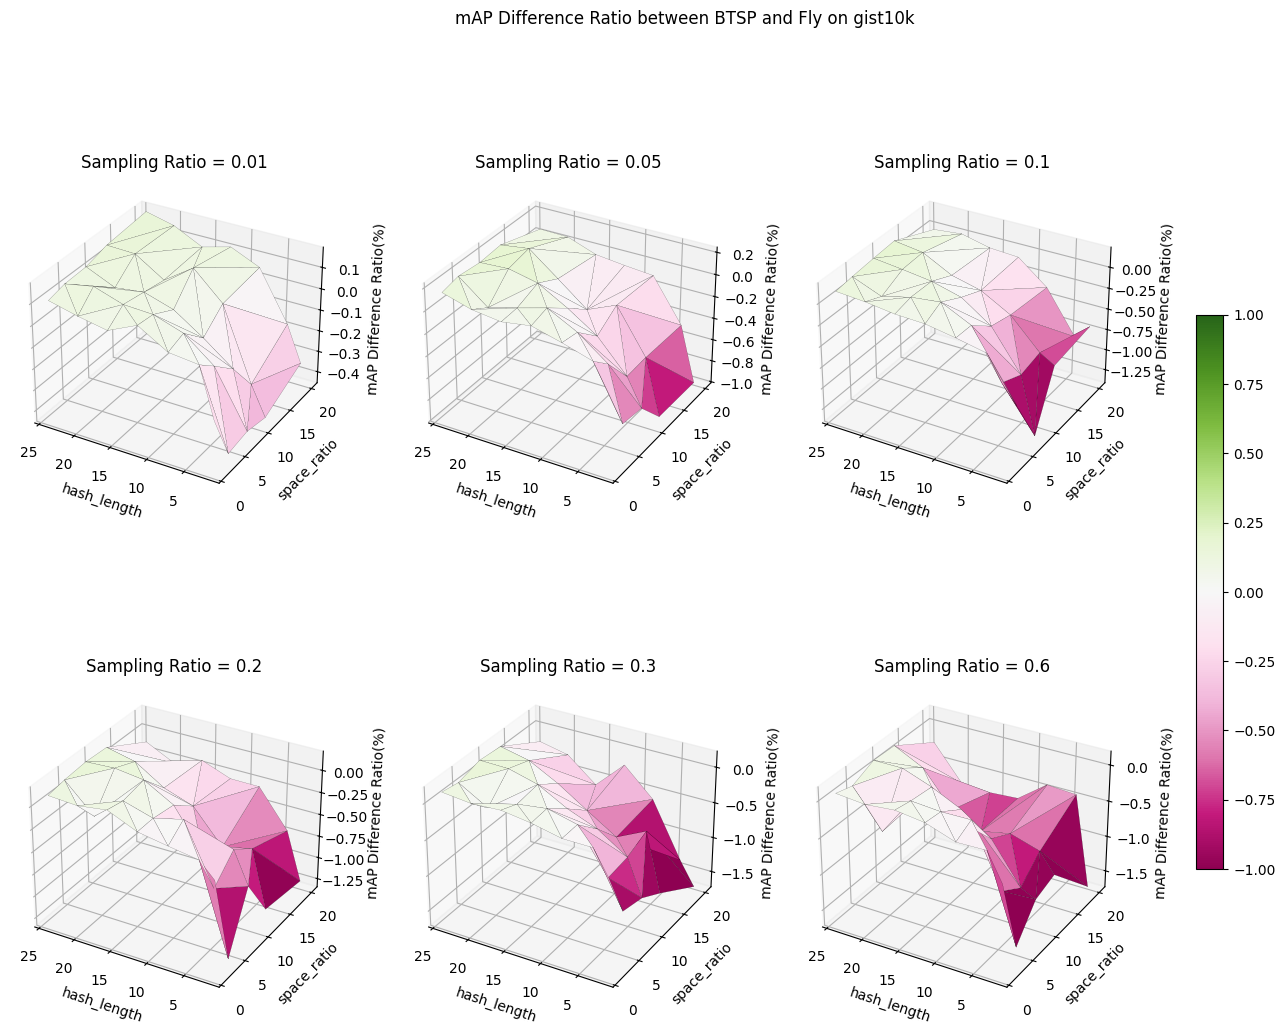

In [13]:
# load results.csv
results = pd.read_csv('merged_results.csv')

# keep the columns we need
# dataset_name, hash_length, space_ratio, binary_mode, sampling_ratio, btsp_mAP and fly_mAP
meta_results = results.drop(columns=["training_data_num", "random_seed", "experiment_index", "input_dim", "embedding_size", "btsp_fq", "wta_mAP", "lsh_mAP"])
# remove index column
meta_results = meta_results.drop(columns=["Unnamed: 0"])
# discard all rows with binary_mode disabled
meta_results = meta_results[meta_results["binary_mode"] == True]
# calculate difference ratio
mAP_diff = meta_results["btsp_mAP"].to_numpy() - meta_results["fly_mAP"].to_numpy()
mAP_min = np.minimum(meta_results["btsp_mAP"].to_numpy(), meta_results["fly_mAP"].to_numpy())
mAP_diff_ratio = mAP_diff / mAP_min
meta_results["mAP_diff_ratio"] = mAP_diff_ratio

# separate data for each dataset
datasets = meta_results["dataset_name"].unique()
for dataset in datasets:
    curr_dataset_data = meta_results[meta_results["dataset_name"] == dataset]
    
    # start plotting
    # get the number of unique sampling_ratio
    sampling_ratios = curr_dataset_data["sampling_ratio"].unique()
    # create a figure with multiple subplots
    subplots_rows = int(np.sqrt(len(sampling_ratios)))
    subplots_cols = int(np.ceil(len(sampling_ratios) / subplots_rows))
    subplot_width = 6
    subplot_height = 6
    fig, axs = plt.subplots(subplots_rows, subplots_cols, subplot_kw={'projection': '3d'}, figsize=(subplots_cols * subplot_width, subplots_rows * subplot_height))
    # use uniform norm
    norm = plt.Normalize(-1, 1)
    # plot each subplot
    for index, sampling_ratio in enumerate(sampling_ratios):
        curr_sampling_data = curr_dataset_data[curr_dataset_data["sampling_ratio"] == sampling_ratio]
        # get the subplot
        if subplots_rows > 1:
            ax = axs[index // subplots_cols, index % subplots_cols]
        else:
            ax = axs[index]
        # plot trisurface
        x = curr_sampling_data["hash_length"].to_numpy()
        y = curr_sampling_data["space_ratio"].to_numpy()
        z = curr_sampling_data["mAP_diff_ratio"].to_numpy()
        ax.plot_trisurf(x, y, z, cmap='PiYG', norm=norm, edgecolor='black', linewidth=0.1)
        # invert hash_length axis
        ax.invert_xaxis()
        # add titles
        ax.set_title("Sampling Ratio = " + str(sampling_ratio))
        ax.set_xlabel("hash_length")
        ax.set_ylabel("space_ratio")
        ax.set_zlabel("mAP Difference Ratio(%)")
    # add a colorbar
    fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='PiYG'), ax=axs, orientation='vertical', shrink=0.6)
    # add figure title
    fig.suptitle("mAP Difference Ratio between BTSP and Fly on " + dataset)
    # show and close
    plt.show()
    plt.close()

From the results, we confirm that the impact of these parameters on the performance of the algorithms is dataset-dependent. For example, on gist10k a larger space ratio generally makes Fly algorithm outperform BTSP algorithm, while the opposite is true for mnist10k. On glove10k Fly outperforms BTSP in almost all cases, while on minst10k the overall scale of the difference ratio is significantly smaller.